In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.layers import Input, Conv2D, PReLU, LeakyReLU, Dense, BatchNormalization, UpSampling2D, Activation, Reshape, GlobalAveragePooling2D, Add
from tqdm import tqdm
from skimage.metrics import structural_similarity as compare_ssim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import datetime
from InstanceNormalization import InstanceNormalization
from dataset import MRIdataGenerator
import keras.backend as K

In [19]:
batch_size = 6

In [20]:
train_generator = MRIdataGenerator("./dataset/training/", batch_size, "cartesian_row")

In [21]:
sample = train_generator.__getitem__(0)

In [22]:
sample[0][1].min(), sample[0][1].max(), sample[1][1].shape, train_generator.__len__()

(-1.0, 0.8391339749909872, (256, 256, 1), 2)

(-0.5, 255.5, 255.5, -0.5)

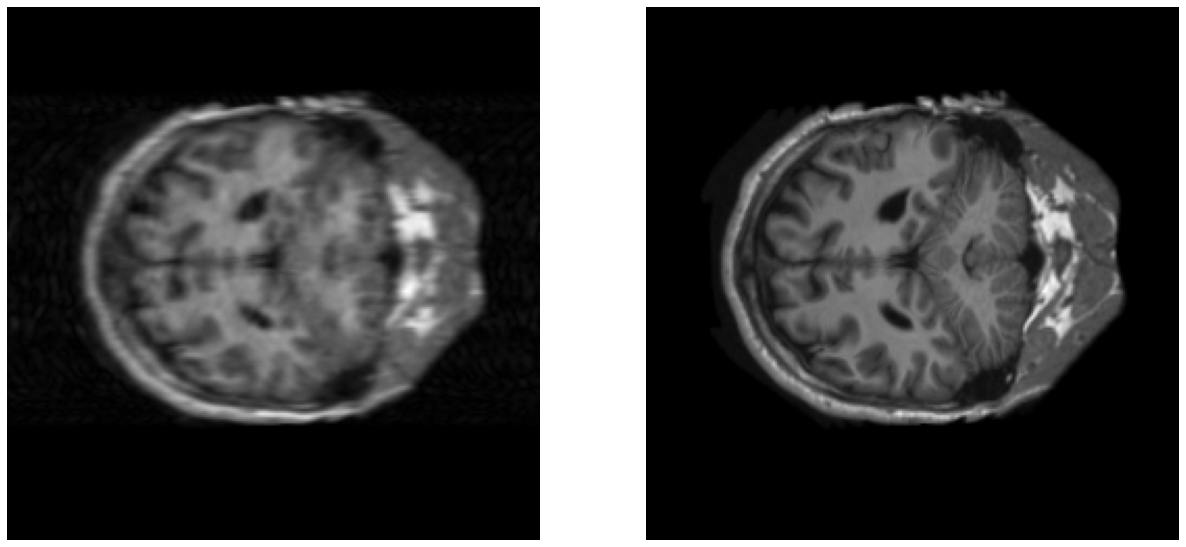

In [17]:
plt.figure(figsize=(21,21))
plt.subplot(121)
plt.imshow(sample[0][0][:,:,0],cmap = "gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(sample[1][0][:,:,0],cmap = "gray")
plt.axis("off")

In [23]:
class CycleGAN(object):
    def __init__(self):
        self.channels = 1
        self.hr_height = 256   
        self.hr_width = 256     
        self.hr_shape = (self.hr_height, self.hr_width, self.channels)

        self.n_residual_blocks = 9

        optimizer = Adam(0.0001, 0.5, 0.99)

        # We use a pre-trained VGG19 model to extract image features from the high resolution
        # and the generated high resolution images and minimize the mse between them
        self.vgg_hq = self.build_vgg_hr(name='vgg_hq')
        self.vgg_hq.trainable = False
        self.vgg_hq_m = self.vgg_hq
        self.vgg_hq_m.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['accuracy'])
        self.vgg_lq = self.build_vgg_hr(name='vgg_lq')
        self.vgg_lq.trainable = False
        self.vgg_lq_m = self.vgg_lq
        self.vgg_lq_m.compile(loss='mse',
                        optimizer=optimizer,
                        metrics=['accuracy'])

        # Calculate output shape of D (PatchGAN)
        patch_hr_h = int(self.hr_height / 2 ** 4)
        patch_hr_w = int(self.hr_width / 2 ** 4)
        self.disc_patch_hr = (patch_hr_h, patch_hr_w, 1)
        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        self.discriminator_hq = self.build_discriminator(name='dis_hq')
        self.discriminator_hq_m = self.discriminator_hq
        self.discriminator_hq_m.compile(loss='mse',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.discriminator_lq = self.build_discriminator(name='dis_lq')
        self.discriminator_lq_m = self.discriminator_lq
        self.discriminator_lq_m.compile(loss='mse',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build the generator
        self.generator_lq2hq = self.build_generator(name='gen_lq2hq')
        self.generator_hq2lq = self.build_generator(name='gen_hq2lq')

        img_lq = Input(shape=self.hr_shape)
        img_hq = Input(shape=self.hr_shape)

        fake_hq = self.generator_lq2hq(img_lq)
        fake_lq = self.generator_hq2lq(img_hq)

        reconstr_lq = self.generator_hq2lq(fake_hq)
        reconstr_hq = self.generator_lq2hq(fake_lq)

        fake_hq_features = self.vgg_hq(fake_hq)
        fake_lq_features = self.vgg_lq(fake_lq)

        reconstr_hq_features = self.vgg_hq(reconstr_hq)
        reconstr_lq_features = self.vgg_lq(reconstr_lq)

        self.discriminator_hq.trainable = False
        self.discriminator_lq.trainable = False

        validity_hq = self.discriminator_hq(fake_hq)
        validity_lq = self.discriminator_lq(fake_lq)

        validity_reconstr_hq = self.discriminator_hq(reconstr_hq)
        validity_reconstr_lq = self.discriminator_lq(reconstr_lq)

        self.combined_hq = Model([img_lq, img_hq], [validity_hq, validity_reconstr_lq,
                                                    fake_hq_features, reconstr_lq_features])
        self.combined_hq_m = self.combined_hq
        self.combined_hq_m.compile(loss=['mse', 'mse', 'mse', 'mse'],
                                   loss_weights=[1e-3, 1e-3, 1, 1],
                                   optimizer=optimizer)
        self.combined_lq = Model([img_lq, img_hq], [validity_lq, validity_reconstr_hq,
                                                    fake_lq_features, reconstr_hq_features])
        self.combined_lq_m = self.combined_lq
        self.combined_lq_m.compile(loss=['mse', 'mse', 'mse', 'mse'],
                                   loss_weights=[1e-3, 1e-3, 1, 1],
                                   optimizer=optimizer)
    

    def build_vgg_hr(self, name=None):

        vgg_model  = VGG19(include_top=False, weights="imagenet")
        vgg_config = vgg_model.get_config()
        h, w, c = 256, 256, 1
        vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)
        vgg_updated = Model.from_config(vgg_config)
        
        def avg_wts(weights):  
            average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  #Find mean along the channel axis (second to last axis)
            return(average_weights)
        
        vgg_updated_config = vgg_updated.get_config()
        vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]


        first_conv_name = vgg_updated_layer_names[1]

        for layer in vgg_model.layers:
            if layer.name in vgg_updated_layer_names:

                if layer.get_weights() != []:  
                    target_layer = vgg_updated.get_layer(layer.name)

                    if layer.name in first_conv_name:    
                        weights = layer.get_weights()[0]
                        biases  = layer.get_weights()[1]

                        weights_single_channel = avg_wts(weights)

                        target_layer.set_weights([weights_single_channel, biases])  
                        target_layer.trainable = False   

                    else:
                        target_layer.set_weights(layer.get_weights())   
                        target_layer.trainable = False  
        
        img = Input(shape=(256,256,1))
        temp = Model(inputs=vgg_updated.inputs, outputs=vgg_updated.layers[10].output)
        img_features = temp(img)
        model = Model(img, img_features, name=name)
        return model

    def SEBlock(self, inputs, filters, ratio=0.25):
        bottleneck_filters = int(filters * ratio)
        se = GlobalAveragePooling2D()(inputs)
        se = Reshape((1,1, inputs.shape[-1]))(se)
        se = Conv2D(bottleneck_filters, (1,1), activation="relu")(se)
        se = Conv2D(filters, (1,1), activation="sigmoid")(se)
        se = tf.math.multiply(se, inputs)
        return se
    
    def build_generator(self, name=None):
        def residual_block(layer_input, filters):
            d = Conv2D(filters, kernel_size=1, strides=1, padding='same')(layer_input)
            d = InstanceNormalization()(d)
            d = Conv2D(filters, kernel_size=4, strides=1, padding='same')(d)
            d = InstanceNormalization()(d)
            d = PReLU()(d)
            d = Conv2D(filters, kernel_size=4, strides=1, padding='same')(d)
            d = InstanceNormalization()(d)
            d = self.SEBlock(d, filters)
            d = Add()([d, layer_input])
            return d

        # Low resolution image input
        img_lr = Input(shape=self.hr_shape)
        c1 = Conv2D(64, kernel_size=7, strides=1, padding='same')(img_lr)
        c1 = InstanceNormalization()(c1)
        c1 = PReLU()(c1)

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            c1 = Conv2D(filters=64 * mult * 2, kernel_size=(3, 3), strides=2, padding='same')(c1)
            c1 = InstanceNormalization()(c1)
            c1 = PReLU()(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf * (n_downsampling ** 2))
        for _ in range(8):
            r = residual_block(r, self.gf * (n_downsampling ** 2))

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            r = UpSampling2D()(r)
            r = Conv2D(filters=int(64 * mult / 2), kernel_size=(3, 3), padding='same')(r)
            r = InstanceNormalization()(r)
            r = PReLU()(r)

            # Post-residual block
        c2 = Conv2D(self.channels, kernel_size=7, strides=1, padding='same')(r)
        c2 = Activation('tanh')(c2)
        c2 = Add()([c2, img_lr])
        model = Model(img_lr, [c2], name=name)


        return model
         


    def build_discriminator(self, name=None):
        n_layers, use_sigmoid = 3, False
        inputs = Input(shape=self.hr_shape)
        ndf=64
        x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding='same')(inputs)
        x = LeakyReLU(0.2)(x)

        nf_mult, nf_mult_prev = 1, 1
        for n in range(n_layers):
            nf_mult_prev, nf_mult = nf_mult, min(2 ** n, 8)
            x = Conv2D(filters=ndf * nf_mult, kernel_size=(4, 4), strides=2, padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(0.2)(x)

        nf_mult_prev, nf_mult = nf_mult, min(2 ** n_layers, 8)
        x = Conv2D(filters=ndf * nf_mult, kernel_size=(4, 4), strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding='same')(x)
        if use_sigmoid:
            x = Activation('sigmoid')(x)

        x = Dense(1024, activation='tanh')(x)
        x = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=x, name=name)

        return model


    def train(self, model, epochs, batch_size):
        start_time = datetime.datetime.now()
        weigths_dir = model + '_weights'
        log_dir = model + '_logs/'
        if not os.path.exists(weigths_dir):
            os.makedirs(weigths_dir)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        logging = []
        import csv
        header = ["Epoch", "G_loss", "D_loss", "SSIM", "PSNR"]
        file = log_dir+ "/cycleGAN_data.csv"
        with open(file, 'w', newline='') as csvfile:
            csvwritter = csv.writer(csvfile)
            csvwritter.writerow(header)
        for epoch in range(epochs):
            d_losses_hr = []
            d_losses_lr = []
            g_losses_hq = []
            g_losses_lq = []
            for b in tqdm(range(0,train_generator.__len__())):
                random_select = b
                imgs_hrlq_train,imgs_hrhq_train = train_generator.__getitem__(random_select)

                if epoch > int(epochs/2):
                    K.set_value(self.discriminator_hq_m.optimizer.lr,
                                1e-4 * (epochs - epoch) / (epochs - int(epochs/2)))
                    K.set_value(self.discriminator_lq_m.optimizer.lr,
                                1e-4 * (epochs - epoch) / (epochs - int(epochs/2)))
                    K.set_value(self.combined_hq_m.optimizer.lr,
                                1e-4 * (epochs - epoch) / (epochs - int(epochs / 2)))
                    K.set_value(self.combined_lq_m.optimizer.lr,
                                1e-4 * (epochs - epoch) / (epochs - int(epochs / 2)))

                # From low res. image generate high res. version

                fake_hrhq = self.generator_lq2hq.predict(imgs_hrlq_train, verbose=0)
                fake_hrlq = self.generator_hq2lq.predict(imgs_hrhq_train,  verbose=0)

                valid_hr = np.ones((batch_size,) + self.disc_patch_hr)
                fake_hr = np.zeros((batch_size,) + self.disc_patch_hr)

                # Train the discriminators (original images = real / generated = Fake)

                d_loss_real_hr = self.discriminator_hq_m.train_on_batch(imgs_hrhq_train, valid_hr)
                d_loss_fake_hr = self.discriminator_hq_m.train_on_batch(fake_hrhq, fake_hr)
                d_loss_hr = 0.5 * np.add(d_loss_real_hr, d_loss_fake_hr)
                d_loss_real_lr = self.discriminator_lq_m.train_on_batch(imgs_hrlq_train, valid_hr)
                d_loss_fake_lr = self.discriminator_lq_m.train_on_batch(fake_hrlq, fake_hr)
                d_loss_lr = 0.5 * np.add(d_loss_real_lr, d_loss_fake_lr)

                # ------------------
                #  Train Generator
                # ------------------

                # The generators want the discriminators to label the generated images as real

                # Extract ground truth image features using pre-trained VGG19 model

                image_features_hq = self.vgg_hq.predict(imgs_hrhq_train, verbose=0)
                image_features_lq = self.vgg_lq.predict(imgs_hrlq_train, verbose=0)

                # Train the generators

                g_loss_hq = self.combined_hq_m.train_on_batch([imgs_hrlq_train, imgs_hrhq_train],
                                                      [valid_hr, valid_hr,
                                                       image_features_hq,
                                                       image_features_lq])
                g_loss_lq = self.combined_lq_m.train_on_batch([imgs_hrlq_train, imgs_hrhq_train],
                                                      [valid_hr, valid_hr,
                                                      image_features_lq,
                                                      image_features_hq])
                d_losses_hr.append(d_loss_hr)
                d_losses_lr.append(d_loss_lr)
                g_losses_hq.append(g_loss_hq)
                g_losses_lq.append(g_loss_lq)
            
            d_losses_hr = np.array(d_losses_hr) 
            d_losses_lr = np.array(d_losses_lr)
            
            d_losses_hr = np.sum(d_losses_hr, axis=0) / len(d_losses_hr)
            d_losses_lr = np.sum(d_losses_lr, axis=0) / len(d_losses_lr)
            
            g_losses_hq = np.array(g_losses_hq)
            g_losses_lq = np.array(g_losses_lq)
            
            g_losses_hq = np.sum(g_losses_hq, axis=0) / len(g_losses_hq)
            g_losses_lq = np.sum(g_losses_lq, axis=0) / len(g_losses_lq)
            elapsed_time = datetime.datetime.now() - start_time
            print('Iteration : ' + str(epoch + 1) + '/' + str(epochs))
            print('time : ' + str(elapsed_time))

            print('D/loss_hq : ' + str(d_losses_hr[0]) + ' D/acc_hq : ' + str(d_losses_hr[1]))
            print('G/loss_hq : ' + str(g_losses_hq[0]) + ' G/acc_hq : ' + str(g_losses_hq[1]))
            if (epoch + 1) % 5 == 0:
                self.generator_lq2hq.save(weigths_dir + "/generator_l2h_" + str(epoch+1) + ".h5")

            if (epoch + 1) % 1 == 0:
                psnr_lr = []
                ssim_lr = []
                PSNR_lr = 0
                SSIM_lr = 0
                ssim = 0
                psnr = 0
                for x in range(0,15):
                    ran = np.random.randint(0, train_generator.__len__())
                    pred = self.generator_lq2hq.predict(train_generator.__getitem__(ran)[0], batch_size=2)
                    ssim_lr.append(compare_ssim(train_generator.__getitem__(ran)[1][0][:,:,0], pred[0][:,:,0], multichannel=False, data_range=2.0))
                    psnr_lr.append(compare_psnr(train_generator.__getitem__(ran)[1][0][:,:,0], pred[0][:,:,0], data_range=2.0))
                ssim_lr = np.array(ssim_lr)
                psnr_lr = np.array(psnr_lr)
                ssim = ssim_lr.sum()/ssim_lr.shape[0]
                psnr = psnr_lr.sum()/psnr_lr.shape[0]
                print("epoch:", epoch+1 ,"ssim:", ssim, "psnr:", psnr)
                logging.append([epoch+1, g_losses_hq[0], d_losses_hr[0], ssim, psnr])
                temp = [epoch+1, g_losses_hq[0], d_losses_hr[0], ssim, psnr]
            else:
                logging.append([epoch+1, g_losses_hq[0], d_losses_hr[0], 0, 0])
                temp = [epoch+1, g_losses_hq[0], d_losses_hr[0], 0, 0]
            if (epoch + 1) == epochs:
                for x in range(0,100):
                    ran = np.random.randint(0, train_generator.__len__())
                    pred = self.generator_lq2hq.predict(train_generator.__getitem__(ran)[0], batch_size=2)
                    row_test = [compare_ssim(train_generator.__getitem__(ran)[1][0][:,:,0], pred[0][:,:,0], multichannel=False, data_range=2.0), compare_psnr(train_generator.__getitem__(ran)[1][0][:,:,0], pred[0][:,:,0], data_range=2.0)]
                    
                    with open(log_dir+"/cycleGAN_test.csv", 'a', newline='') as csvfile1:
                        csvwritter1 = csv.writer(csvfile1)
                        csvwritter1.writerow(row_test)
                    
            with open(file, 'a', newline='') as csvfile:
                csvwritter = csv.writer(csvfile)
                csvwritter.writerow(temp)
        return logging

In [24]:
dcgan = CycleGAN()
epoch = 50
model = 'miccia_data_cartesian_row'
logging = dcgan.train(model=model, epochs=epoch, batch_size=batch_size)

100%|██████████| 750/750 [24:09<00:00,  1.93s/it]


Iteration : 1/50
time : 0:24:09.782523
D/loss_hq : 0.05082719484973488 D/acc_hq : 0.9338758683083579
G/loss_hq : 3.778011427561442 G/acc_hq : 0.3543422249574214


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 1 ssim: 0.9332262019781105 psnr: 31.866612137965298


100%|██████████| 750/750 [23:34<00:00,  1.89s/it]


Iteration : 2/50
time : 0:47:50.288194
D/loss_hq : 0.018560985136225863 D/acc_hq : 0.9781440967420737
G/loss_hq : 1.6361388884385426 G/acc_hq : 0.33384023322723805


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 2 ssim: 0.958351435466207 psnr: 35.20426349633177


100%|██████████| 750/750 [23:31<00:00,  1.88s/it]


Iteration : 3/50
time : 1:11:27.640360
D/loss_hq : 0.007748139698622673 D/acc_hq : 0.990576388652126
G/loss_hq : 1.220117081562678 G/acc_hq : 0.37181990026139344


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 3 ssim: 0.9569157552536663 psnr: 35.498600243135535


100%|██████████| 750/750 [23:19<00:00,  1.87s/it]


Iteration : 4/50
time : 1:34:52.204257
D/loss_hq : 0.0024337890306344806 D/acc_hq : 0.9971267361243565
G/loss_hq : 0.9926941010951996 G/acc_hq : 0.5884523745151237


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 4 ssim: 0.9631229634801642 psnr: 36.61518335286027


100%|██████████| 750/750 [23:25<00:00,  1.87s/it]


Iteration : 5/50
time : 1:58:22.752104
D/loss_hq : 0.0006016624101760864 D/acc_hq : 0.9992452257076899
G/loss_hq : 0.8304268914063772 G/acc_hq : 0.6910916189054648


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 5 ssim: 0.9594952280543808 psnr: 36.04474872681018


100%|██████████| 750/750 [23:40<00:00,  1.89s/it]


Iteration : 6/50
time : 2:22:08.580311
D/loss_hq : 0.000798388435256708 D/acc_hq : 0.9990564235846202
G/loss_hq : 0.7149226442972819 G/acc_hq : 0.7364732266267155


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 6 ssim: 0.9632091257290554 psnr: 36.52542696254122


100%|██████████| 750/750 [23:19<00:00,  1.87s/it]


Iteration : 7/50
time : 2:45:32.446554
D/loss_hq : 0.0013292974400422033 D/acc_hq : 0.9984440104564031
G/loss_hq : 0.6183909008900325 G/acc_hq : 0.5610608626492322


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 7 ssim: 0.953057810403535 psnr: 34.823119238753044


100%|██████████| 750/750 [23:22<00:00,  1.87s/it]


Iteration : 8/50
time : 3:08:59.857906
D/loss_hq : 0.00037736950624456137 D/acc_hq : 0.9995933159987131
G/loss_hq : 0.5389156204462051 G/acc_hq : 0.7034356674551964


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 8 ssim: 0.9646863561486728 psnr: 36.80349480499935


100%|██████████| 750/750 [23:23<00:00,  1.87s/it]


Iteration : 9/50
time : 3:32:27.982807
D/loss_hq : 0.0005664687352291088 D/acc_hq : 0.9993242187102636
G/loss_hq : 0.48205356011788053 G/acc_hq : 0.6147329074839751


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 9 ssim: 0.9610952593003547 psnr: 36.47164290387628


100%|██████████| 750/750 [23:26<00:00,  1.88s/it]


Iteration : 10/50
time : 3:55:59.760441
D/loss_hq : 8.968313232163838e-05 D/acc_hq : 0.9998971353371938
G/loss_hq : 0.4305031499862671 G/acc_hq : 0.7507808563907942


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 10 ssim: 0.958775151281199 psnr: 35.835808403689846


100%|██████████| 750/750 [23:19<00:00,  1.87s/it]


Iteration : 11/50
time : 4:19:24.147725
D/loss_hq : 0.0006737546076463271 D/acc_hq : 0.9991957465012868
G/loss_hq : 0.386048670232296 G/acc_hq : 0.635907556851705


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 11 ssim: 0.9637810617063907 psnr: 36.92266369461133


100%|██████████| 750/750 [23:23<00:00,  1.87s/it]


Iteration : 12/50
time : 4:42:52.618185
D/loss_hq : 0.0008407177443560574 D/acc_hq : 0.9990125867525737
G/loss_hq : 0.35257494044303894 G/acc_hq : 0.7243767290636897


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 12 ssim: 0.9624273234070394 psnr: 36.658358681316074


100%|██████████| 750/750 [23:30<00:00,  1.88s/it]


Iteration : 13/50
time : 5:06:27.368099
D/loss_hq : 0.0006558881334292396 D/acc_hq : 0.9992560763955116
G/loss_hq : 0.3217882664998372 G/acc_hq : 0.5067509262164434


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 13 ssim: 0.9673425857724068 psnr: 37.26365003036462


100%|██████████| 750/750 [23:19<00:00,  1.87s/it]


Iteration : 14/50
time : 5:29:51.806312
D/loss_hq : 0.00023178448178499044 D/acc_hq : 0.9997287326256434
G/loss_hq : 0.2949908250570297 G/acc_hq : 0.5820628311534722


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 14 ssim: 0.9691662563403436 psnr: 37.60810841632267


100%|██████████| 750/750 [23:22<00:00,  1.87s/it]


Iteration : 15/50
time : 5:53:19.849589
D/loss_hq : 0.0016136826512719881 D/acc_hq : 0.9982113715882103
G/loss_hq : 0.2921587703625361 G/acc_hq : 0.518912482654055


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 15 ssim: 0.966532374520097 psnr: 37.49140520023657


100%|██████████| 750/750 [23:19<00:00,  1.87s/it]


Iteration : 16/50
time : 6:16:44.258044
D/loss_hq : 0.00022206468798272624 D/acc_hq : 0.9997300347089767
G/loss_hq : 0.25720726573467256 G/acc_hq : 0.4509054945210616


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 16 ssim: 0.9723735602246191 psnr: 38.68953040637295


100%|██████████| 750/750 [23:22<00:00,  1.87s/it]


Iteration : 17/50
time : 6:40:11.149677
D/loss_hq : 0.0006038214170408956 D/acc_hq : 0.9992999132474264
G/loss_hq : 0.24224252606431643 G/acc_hq : 0.5185270302395026


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 17 ssim: 0.9715080270730312 psnr: 38.41741338052175


100%|██████████| 750/750 [23:27<00:00,  1.88s/it]


Iteration : 18/50
time : 7:03:43.650643
D/loss_hq : 0.0003621511378676503 D/acc_hq : 0.9995802951256434
G/loss_hq : 0.2294197135368983 G/acc_hq : 0.725986774802208


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 18 ssim: 0.972985295855899 psnr: 38.46709531841633


100%|██████████| 750/750 [23:33<00:00,  1.88s/it]


Iteration : 19/50
time : 7:27:22.089269
D/loss_hq : 0.0004975298700904435 D/acc_hq : 0.9994179686705271
G/loss_hq : 0.22134474274516105 G/acc_hq : 0.6832911598483722


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 19 ssim: 0.9731093772720574 psnr: 38.19133640464954


100%|██████████| 750/750 [23:27<00:00,  1.88s/it]


Iteration : 20/50
time : 7:50:54.113236
D/loss_hq : 0.0010633837098324814 D/acc_hq : 0.9988511284726361
G/loss_hq : 0.20531016783912975 G/acc_hq : 0.7269590119123459


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 20 ssim: 0.9704228755830366 psnr: 38.41499185820081


100%|██████████| 750/750 [23:25<00:00,  1.87s/it]


Iteration : 21/50
time : 8:14:24.890909
D/loss_hq : 0.0007487657964004715 D/acc_hq : 0.9991067706743876
G/loss_hq : 0.1965455742875735 G/acc_hq : 0.4844453691629072


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 21 ssim: 0.9738291466469611 psnr: 38.98157016408954


100%|██████████| 750/750 [23:22<00:00,  1.87s/it]


Iteration : 22/50
time : 8:37:52.288907
D/loss_hq : 0.00010665198057647689 D/acc_hq : 0.9998680555423101
G/loss_hq : 0.1888314824104309 G/acc_hq : 0.6647454102834066


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 22 ssim: 0.9712882619523305 psnr: 38.394479639332886


100%|██████████| 750/750 [23:34<00:00,  1.89s/it]


Iteration : 23/50
time : 9:01:31.709016
D/loss_hq : 0.0009987047884796828 D/acc_hq : 0.9987664930820465
G/loss_hq : 0.17875379075606665 G/acc_hq : 0.7438104132811229


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 23 ssim: 0.9700157734491378 psnr: 38.26427827103021


100%|██████████| 750/750 [23:28<00:00,  1.88s/it]


Iteration : 24/50
time : 9:25:06.225999
D/loss_hq : 0.0008530089709070161 D/acc_hq : 0.9989934895833333
G/loss_hq : 0.17309754369656244 G/acc_hq : 0.8892904251813889


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 24 ssim: 0.9762127215502214 psnr: 39.48727905163768


100%|██████████| 750/750 [23:23<00:00,  1.87s/it]


Iteration : 25/50
time : 9:48:34.499727
D/loss_hq : 0.0009045628788629922 D/acc_hq : 0.99902430554231
G/loss_hq : 0.17547877874970436 G/acc_hq : 0.7566617274681727


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 25 ssim: 0.9737394617192839 psnr: 38.616609646041105


100%|██████████| 750/750 [23:28<00:00,  1.88s/it]


Iteration : 26/50
time : 10:12:08.049854
D/loss_hq : 0.00027198640986899876 D/acc_hq : 0.9996675346692403
G/loss_hq : 0.1584890947242578 G/acc_hq : 0.3323885141722858


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 26 ssim: 0.9769935694137672 psnr: 39.59423299725593


100%|██████████| 750/750 [23:34<00:00,  1.89s/it]


Iteration : 27/50
time : 10:35:47.462563
D/loss_hq : 0.0007801435390248433 D/acc_hq : 0.9991028646032015
G/loss_hq : 0.15104039886593817 G/acc_hq : 0.6219507469460368


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 27 ssim: 0.9712443404297494 psnr: 38.68634993290149


100%|██████████| 750/750 [23:23<00:00,  1.87s/it]


Iteration : 28/50
time : 10:59:15.558991
D/loss_hq : 0.0006366797839805601 D/acc_hq : 0.99929991320769
G/loss_hq : 0.1405182088315487 G/acc_hq : 0.6601461539467176


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 28 ssim: 0.9754629507737569 psnr: 39.26718187887433


100%|██████████| 750/750 [23:25<00:00,  1.87s/it]


Iteration : 29/50
time : 11:22:45.622992
D/loss_hq : 0.00022449697550689125 D/acc_hq : 0.9997048610846202
G/loss_hq : 0.134274522403876 G/acc_hq : 0.7103397755424181


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 29 ssim: 0.9736829746286964 psnr: 39.01942570826019


100%|██████████| 750/750 [23:29<00:00,  1.88s/it]


Iteration : 30/50
time : 11:46:19.983314
D/loss_hq : 0.0002813129840173959 D/acc_hq : 0.9996731770435969
G/loss_hq : 0.12443895012140274 G/acc_hq : 0.6667163228591283


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 30 ssim: 0.9746603424875054 psnr: 39.36220063344661


100%|██████████| 750/750 [23:45<00:00,  1.90s/it]


Iteration : 31/50
time : 12:10:10.769178
D/loss_hq : 0.00026031088396719077 D/acc_hq : 0.9996827257076899
G/loss_hq : 0.11840024434526761 G/acc_hq : 0.544370045085748


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 31 ssim: 0.9762291484807173 psnr: 39.670525741768806


100%|██████████| 750/750 [23:28<00:00,  1.88s/it]


Iteration : 32/50
time : 12:33:44.158047
D/loss_hq : 3.596209023919549e-05 D/acc_hq : 0.9999561631679534
G/loss_hq : 0.11148671661317348 G/acc_hq : 0.6648683379689853


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 32 ssim: 0.9753110938054659 psnr: 39.44647683613093


100%|██████████| 750/750 [23:26<00:00,  1.88s/it]


Iteration : 33/50
time : 12:57:15.915417
D/loss_hq : 0.00063953766248865 D/acc_hq : 0.9992322047948837
G/loss_hq : 0.10438847539325555 G/acc_hq : 0.7571144378185273


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 33 ssim: 0.9764590803704286 psnr: 39.231846576096174


100%|██████████| 750/750 [23:30<00:00,  1.88s/it]


Iteration : 34/50
time : 13:20:51.282165
D/loss_hq : 0.0001604843438882583 D/acc_hq : 0.9998111978769303
G/loss_hq : 0.09806821432212988 G/acc_hq : 0.7585651129881541


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 34 ssim: 0.9752639308695443 psnr: 39.43298459513927


100%|██████████| 750/750 [23:25<00:00,  1.87s/it]


Iteration : 35/50
time : 13:44:22.096964
D/loss_hq : 7.346903413252135e-05 D/acc_hq : 0.9999097222089768
G/loss_hq : 0.09258616805076599 G/acc_hq : 0.7886967766284942


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 35 ssim: 0.9734761672136406 psnr: 38.87433519090668


100%|██████████| 750/750 [23:21<00:00,  1.87s/it]


Iteration : 36/50
time : 14:07:49.774388
D/loss_hq : 0.00022055413062221373 D/acc_hq : 0.9997317708730697
G/loss_hq : 0.08732296460866928 G/acc_hq : 0.8011441009044648


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 36 ssim: 0.9769234848468756 psnr: 39.69500914861843


100%|██████████| 750/750 [23:25<00:00,  1.87s/it]


Iteration : 37/50
time : 14:31:20.611921
D/loss_hq : 0.0013376915750706031 D/acc_hq : 0.9985295138491007
G/loss_hq : 0.08227898447712262 G/acc_hq : 0.9159912420113882


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 37 ssim: 0.9758128304658323 psnr: 39.70593694010873


100%|██████████| 750/750 [23:26<00:00,  1.88s/it]


Iteration : 38/50
time : 14:54:51.723524
D/loss_hq : 0.0006978563980100141 D/acc_hq : 0.9992573784987132
G/loss_hq : 0.07769131277501583 G/acc_hq : 0.806933628877004


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 38 ssim: 0.9760787566053774 psnr: 39.64430105628181


100%|██████████| 750/750 [23:20<00:00,  1.87s/it]


Iteration : 39/50
time : 15:18:17.222970
D/loss_hq : 0.00041224251331716395 D/acc_hq : 0.9994652777512868
G/loss_hq : 0.07313252938290438 G/acc_hq : 0.5946792674064636


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 39 ssim: 0.9811749055403768 psnr: 40.8919094720128


100%|██████████| 750/750 [23:28<00:00,  1.88s/it]


Iteration : 40/50
time : 15:41:50.302518
D/loss_hq : 3.139968817301695e-07 D/acc_hq : 1.0
G/loss_hq : 0.0690934105614821 G/acc_hq : 0.8906501647631327


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 40 ssim: 0.9800369581628267 psnr: 40.649009691190464


100%|██████████| 750/750 [23:33<00:00,  1.88s/it]


Iteration : 41/50
time : 16:05:29.007149
D/loss_hq : 0.0009353260050751425 D/acc_hq : 0.998921006878217
G/loss_hq : 0.064942101602753 G/acc_hq : 0.744366449435552


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 41 ssim: 0.9780195425814856 psnr: 40.03658685234733


100%|██████████| 750/750 [23:28<00:00,  1.88s/it]


Iteration : 42/50
time : 16:29:02.426250
D/loss_hq : 0.0003765305615033664 D/acc_hq : 0.9995555555423101
G/loss_hq : 0.061346830422679584 G/acc_hq : 0.4954227939248085


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 42 ssim: 0.9773891561403144 psnr: 39.95987463357142


100%|██████████| 750/750 [23:34<00:00,  1.89s/it]


Iteration : 43/50
time : 16:52:41.759284
D/loss_hq : 7.292246070061858e-06 D/acc_hq : 0.9999913194576899
G/loss_hq : 0.05819518608848254 G/acc_hq : 0.6219195869763692


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 43 ssim: 0.9747785665752995 psnr: 39.434924947822346


100%|██████████| 750/750 [23:27<00:00,  1.88s/it]


Iteration : 44/50
time : 17:16:14.254826
D/loss_hq : 1.178927488153523e-05 D/acc_hq : 0.9999826388756434
G/loss_hq : 0.05476533275842667 G/acc_hq : 0.6553245276610057


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 44 ssim: 0.9768582745139903 psnr: 39.7414663183316


100%|██████████| 750/750 [23:27<00:00,  1.88s/it]


Iteration : 45/50
time : 17:39:46.959448
D/loss_hq : 0.00011596116095288548 D/acc_hq : 0.9998532985846201
G/loss_hq : 0.05175808199495077 G/acc_hq : 0.4382858800093333


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 45 ssim: 0.9802426720031356 psnr: 40.72295582358232


100%|██████████| 750/750 [23:34<00:00,  1.89s/it]


Iteration : 46/50
time : 18:03:26.144672
D/loss_hq : 4.019761273450924e-06 D/acc_hq : 0.9999947916269303
G/loss_hq : 0.049395333903531236 G/acc_hq : 0.49741200095415117


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 46 ssim: 0.9748521052371412 psnr: 39.47910361470408


100%|██████████| 750/750 [23:38<00:00,  1.89s/it]


Iteration : 47/50
time : 18:27:09.704440
D/loss_hq : 7.884097281254641e-07 D/acc_hq : 0.9999986979166666
G/loss_hq : 0.047107739066084224 G/acc_hq : 0.42194391946991283


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 47 ssim: 0.9768696108318945 psnr: 39.78809907127207


100%|██████████| 750/750 [23:30<00:00,  1.88s/it]


Iteration : 48/50
time : 18:50:44.638332
D/loss_hq : 7.237693490748221e-08 D/acc_hq : 1.0
G/loss_hq : 0.04597345650444428 G/acc_hq : 0.33247040716807047


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 48 ssim: 0.976303712863734 psnr: 39.98580507281853


100%|██████████| 750/750 [23:32<00:00,  1.88s/it]


Iteration : 49/50
time : 19:14:22.305770
D/loss_hq : 3.7721833767377483e-07 D/acc_hq : 0.9999995659589768
G/loss_hq : 0.04571747686962287 G/acc_hq : 0.6456286992232004


  0%|          | 0/750 [00:00<?, ?it/s]

epoch: 49 ssim: 0.976466813717472 psnr: 39.71048100542008


100%|██████████| 750/750 [23:27<00:00,  1.88s/it]


Iteration : 50/50
time : 19:37:54.383084
D/loss_hq : 1.2954295138229022e-08 D/acc_hq : 1.0
G/loss_hq : 0.045743138253688816 G/acc_hq : 0.5031752984921137
epoch: 50 ssim: 0.9787198752981868 psnr: 40.3604546199538
